# Throw Lane, Throw Game?
## A Student Anylysis of LoL

Im a three year sober Leauge of legends player, but seem to find this game yet still stealing time from my life. I've seen numerous write ups of the state of the game pop up over the years, and it looks like I finally get a chance to contribue to them! Using the 'leauge of legneds diamond-ranked-games-10-minutes' that's a little over two years old now, we'll poke around at some of the data.

Limitation: Uptop; leauge is a stupidly complex game, with ten unique characters from a roster of over a hundred being piloted by players with as diverse skill ranges as expectations on what being a 'good' human being is. Arcane was very good, and should not convince anyone to play it. The data here is solid; but is missing a number of key features of the modern age of leauge, most namley however, of plates. Additionally, I monkeyed with the data to allow for an easier creation of graphs / displaying of it, to result in some (likely) data leakage that makes the machine learning model for this meh at best.

Summary: Gold and experiance are key. The team with the higher gold and or experiance (they are nearly 1:1 correlated) at the ten minute mark has a dramaticlly higher chance of winning the game. This is best predicted by in order,kills,CS,and *then* objectives. Losing an early tower, dragon, or herald is by my estamate about half as bad as signifigently being down in CS. Objectives are risky, diffucult things to take early, and a players time is better spent not dying and farming. Or, even better, killing your oponent so you can farm and they can't. This says nothing for the value of these things later on, as in my personal experiance this order seems to flip making objectives the most valuable, but broad advice is to focus first and formost on your economy.

So! That said, lets get this started.

In [150]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv


In [151]:
# Import all those tasty packages and datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
#Preping our enviorment and tinkering with display settings
%matplotlib inline
sns.set_style('whitegrid')
df = pd.read_csv('../input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv')
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


## That's alot of data.
We will be largely ignoring red side for our anylsis, as we want to examine what the 
individual player can see and account for, most all operations we want to do with red side include subtracting it from blue (to determine
gold difference and the like). 

### Predictions

Previous anylsis by other authors point to the imediate spike of winrate (circa 10%) for getting first blood,while a common 
metric for determing how games are progressing at the pro-level often look at the gold difference. While I don't believe examing gold
difference to be an inaccurate measurement and usefull for game prediction, I believe the more actionable data is in the player quantifiable 
variables; towers, epics, kills and the like. Below are some of the key pieces of data I believe worthy of deeper examination.


In [153]:
#previeing what we believe to be key data
preview_columns = ['blueWins', 'blueTotalGold','blueTotalMinionsKilled','blueKills','blueFirstBlood','blueTowersDestroyed']
df[preview_columns].head()

,blueWins,blueTotalGold,blueTotalMinionsKilled,blueKills,blueFirstBlood,blueTowersDestroyed
0,0,17210,195,9,1,0
1,0,14712,174,5,0,0
2,0,16113,186,7,0,0
3,0,15157,201,4,0,0
4,0,16400,210,6,0,0


The next section is of little use to casual reader, but this chunk of df.info() is *invaluable* for referecing ID names and figuring out if anything odd's going on with our data. (Like missmatching variable types, or data that's outright missing)

In [154]:
# check missing values and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

## Curse of Dimensionality

Do houses with green door's cost more? Of course not; but our data would disagree, and argue that green doors can
cause a house to cost thousands more. This can happen when we have unnessary data point's attached to our data that matters, how many rooms
has, how old the building is, how much murder happened there etc..

We have the potentional of causing such an issue here, with such a massive range of data. Now, our sample size is large enough (almost 10,000 
datapoints!) That we could likely leave all this data in, but for the sake of simplicity and readability, I will be cutting a signifigent 
portion of the above data, especially from red side, as we are unintrested in color side difference here and only plan to use red side for 
calculating missing difs. 

In [155]:
df_clean = df.copy()
#Cutting our data to make it more managable
cleaned_collums = [
    'gameId',
    'blueWins',
    'blueFirstBlood',
    'blueKills',
    'blueAssists',
    'blueDragons',
    'blueHeralds',
    'blueTowersDestroyed',
    'blueTotalMinionsKilled',
    'blueTotalJungleMinionsKilled',
    'blueGoldDiff',
    'blueExperienceDiff',
    'redKills',
    'redAssists',
    'redDragons',
    'redHeralds',
    'redTowersDestroyed',
    'redTotalMinionsKilled',
    'redTotalJungleMinionsKilled',
]
df_clean = df_clean[cleaned_collums]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   gameId                        9879 non-null   int64
 1   blueWins                      9879 non-null   int64
 2   blueFirstBlood                9879 non-null   int64
 3   blueKills                     9879 non-null   int64
 4   blueAssists                   9879 non-null   int64
 5   blueDragons                   9879 non-null   int64
 6   blueHeralds                   9879 non-null   int64
 7   blueTowersDestroyed           9879 non-null   int64
 8   blueTotalMinionsKilled        9879 non-null   int64
 9   blueTotalJungleMinionsKilled  9879 non-null   int64
 10  blueGoldDiff                  9879 non-null   int64
 11  blueExperienceDiff            9879 non-null   int64
 12  redKills                      9879 non-null   int64
 13  redAssists                    987

## Graphs. Lots of Graphs. 

Okay, so there's lots going on here, but we will be ignoring alot of this data later on. There are a couple of interesting things about these though, so they warrent some inspection.

### Reading these Graphs 
Their wierd! The X axis is on the left side, while the Y axis rests at the bottom of ALL the charts. Ie, the top left 
chart is blueWins and blueWins(hence, why its just a bar) while blueKills and blueExperianceDiff is the top right histogram. 

### Note: Blue Wins
Is the most obvious graph to look to, but is the most obtuse. It gives us a rather strong indicator already as to the importance of gold and experiance (as indicated by the top right corner graphs) while kills remain a lesser predictor. Oddly, kills Are a stronger predictor of success on the red side, which aligns with what some folk *assume* with Red side, but I think we need more evidence.
### Note: Highly Correlation
Beyond that, almost all the data is too highly correlated to make any sweeping assertions yet. As such, lets make matrix to see this better. This actually becomes a signifigent issue later down the line; some aspects (like gold and experiance) were so closly entwined to have resulted in some of my early models having a .998 prediction rate which was, as usual, wrong.

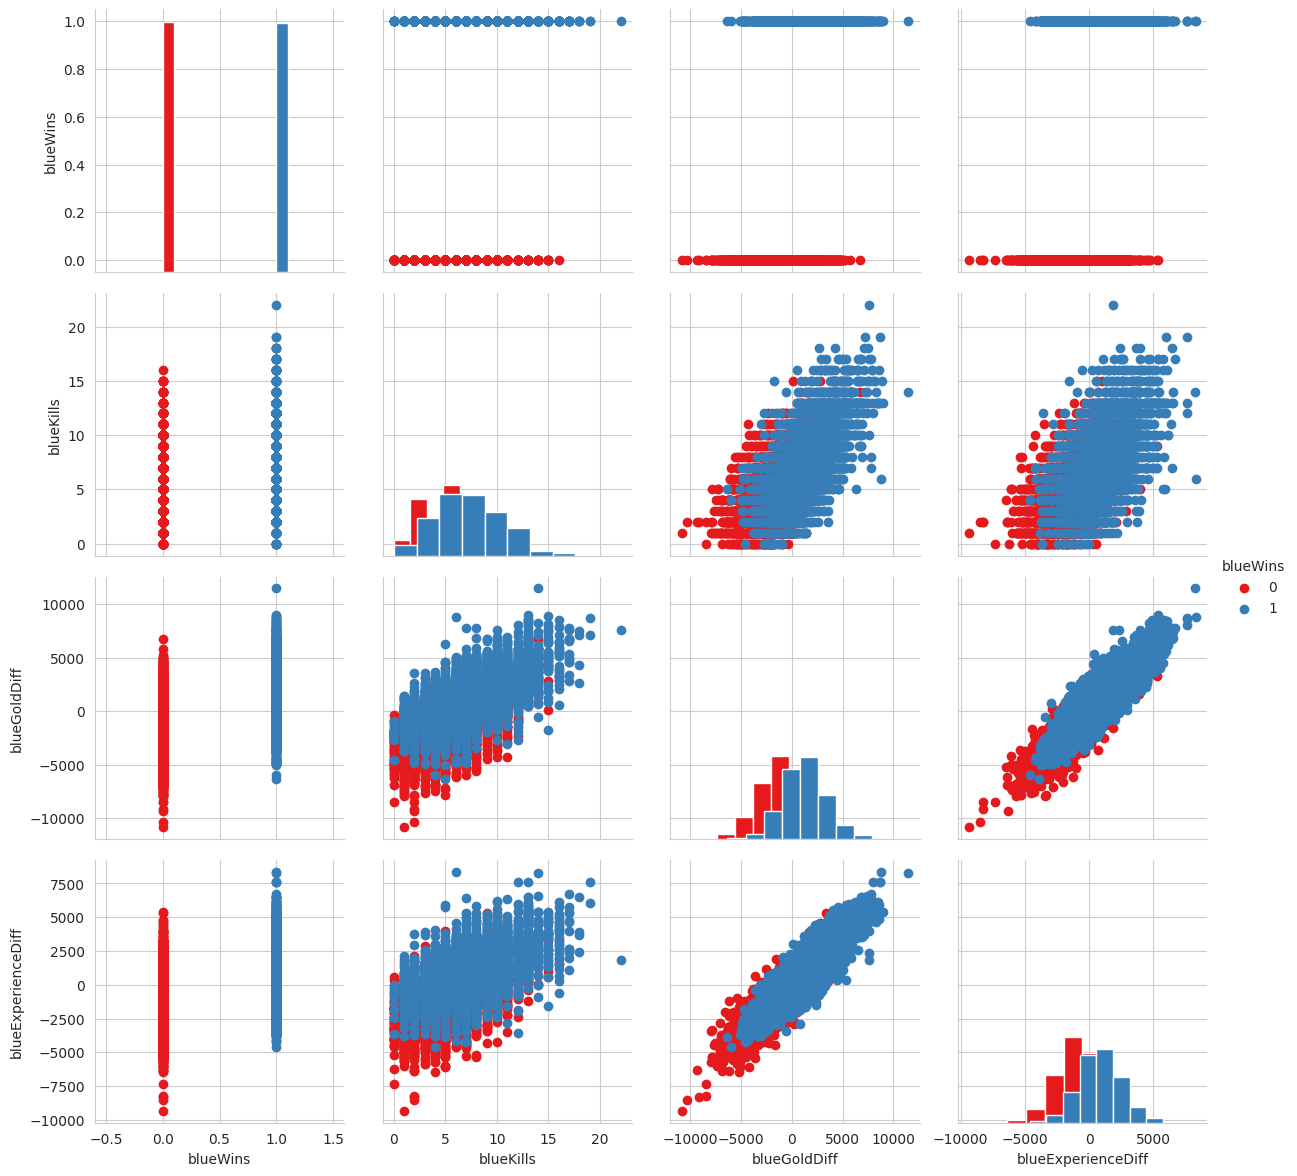

In [156]:
g = sns.PairGrid(data=df_clean, vars=['blueWins', 'blueKills', 'blueGoldDiff', 'blueExperienceDiff'], hue='blueWins', height=3, palette='Set1')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

## Histogram

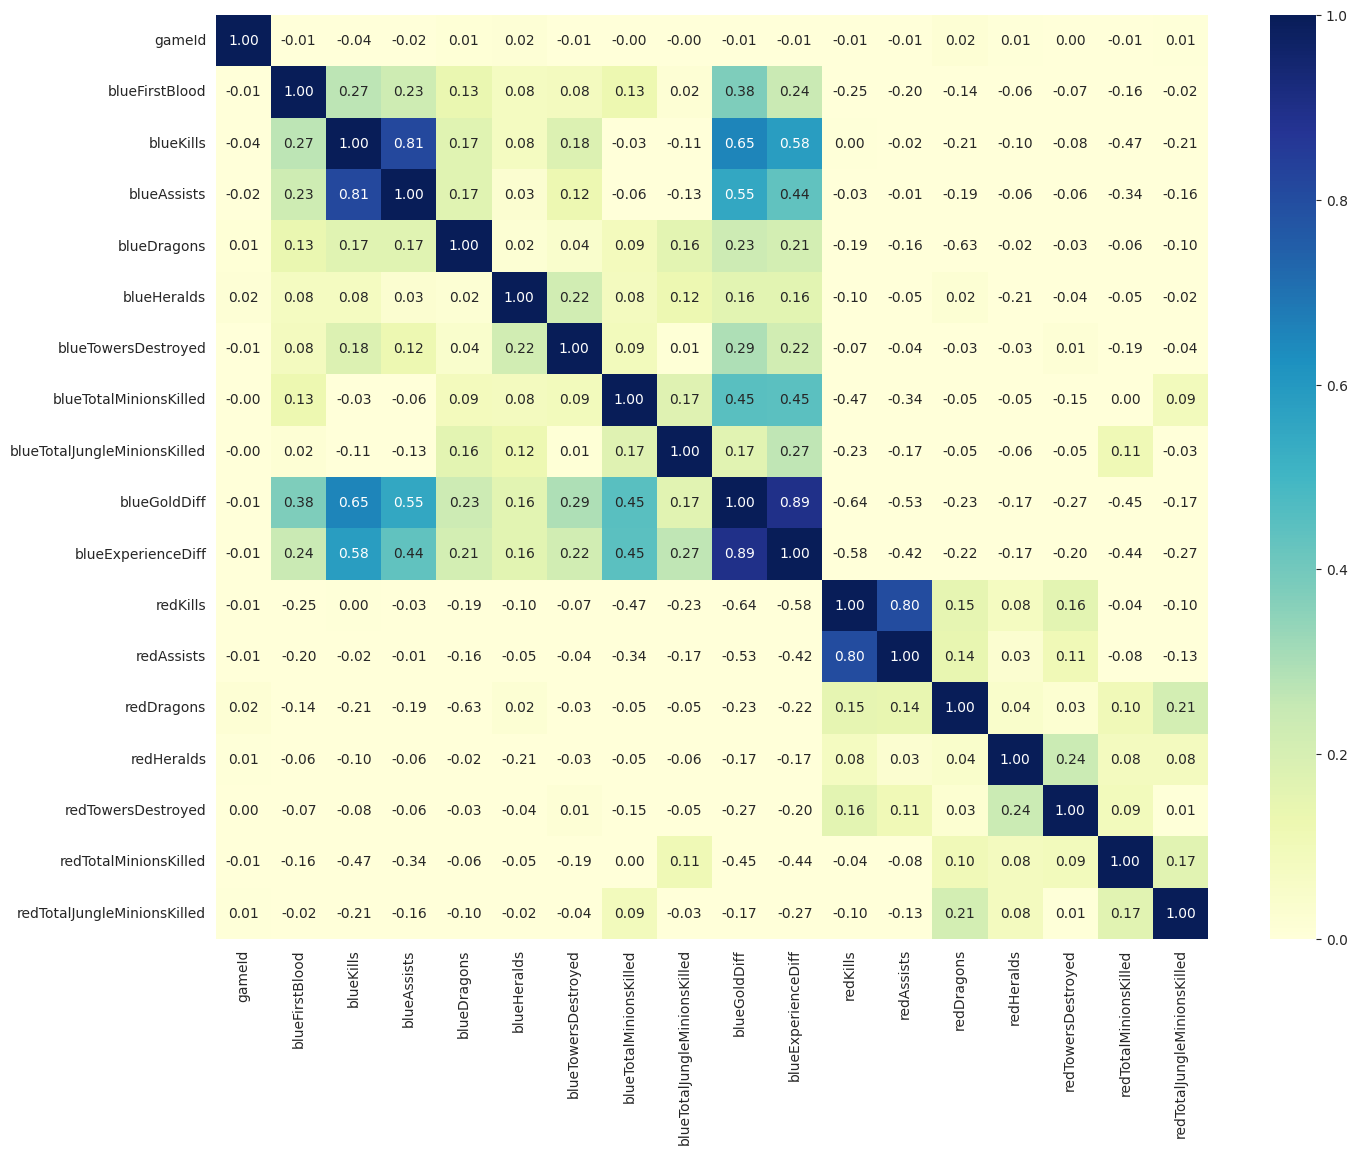

In [157]:
plt.figure(figsize=(16, 12))
sns.heatmap(df_clean.drop('blueWins', axis=1).corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0);

## Histogram!

Based on our chart below, we can cut a few more variables. Our cuts come from places where we see correlations that are too
heavily tied to one thing, rather than appearing in multiple places in our data with distinct interactions with other pieces of the data.
A good example for this is assists; while they are correlated with Kills, Gold, and Experiance differences, they essentially act as an 
inferier version of that data, having the same correlations but to a weaker extent.Even with that said, it's still worth keeping due to it's
high correlation.

We're going for a rather moderate correlation (.3) as our barrior, on account to this being a video-game, and us being wrong and including
somthing not important is not a big deal. There are some intersting correlations I noticed that we cut though, listed below. It is notworthy
that some variables do have a signifigent negative correlation at times; but those are only negative because they are a competing value (such 
as with red vs blue dragons )and therefore should still be cut. 

### Dragons / Heralds: 
Suprisngly little correlation. This makes sense though; taking these objectives often correlates to sacraficing something else such as CS or lane preasure, a factor that likely evens out in the long haul, but makes these early objectives questionable to take before ten minutes, especially considering how risky taking these this early can be. 

### Total Jungle Minions Killed: 
Another low correlation. This may depend on your jungler (as those that 'full clear' need more minions to scale) but evidence here supports that a jungle has to balance CS to pressuring lanes or that one individuals CS has little impact on the end game state.

### Towers / CS: 
Thier correlation here is low, but I believe the data is missing something key; the difference between the two groups. As such, were going to cut them below, but not until we've made an addition to our table. 

### Modifying Variables:
Below were gonna monkey with our variables, and normalize it for usage in a dataset where lots of things have an inverse relationship.

In [158]:

#modfying our initial values to more closly reflect information relevant to the game, given the inverse nature of the variables
df_clean['blueTotalMinionsDifference'] = df_clean['blueTotalMinionsKilled'] - df_clean['redTotalMinionsKilled']
df_clean['blueTowersDifference'] = df_clean['blueTowersDestroyed'] - df_clean['redTowersDestroyed']
df_clean['blueKillsDifference'] = df_clean['blueKills'] - df_clean['redKills']
df_clean['blueAssistsDifference'] = df_clean['blueAssists'] - df_clean['redAssists']
df_clean['blueEpicMonsterDifference'] = (df_clean['blueDragons'] + df_clean['blueHeralds']) - (df_clean['redDragons'] + df_clean['redHeralds'])


A secondary plus, all that consolidation makes our graphs much cleaner! Frankly, I should have cleaned the data sooner, but we
(hopefully) learn from our mistakes.

In [159]:
cut_collumns = [
    'blueDragons',
    'blueHeralds',
    'redDragons',
    'redHeralds',
    'redTotalJungleMinionsKilled',
    'blueTotalJungleMinionsKilled',
    'blueTotalMinionsKilled',
    'redTotalMinionsKilled',
    'blueTowersDestroyed',
    'redTowersDestroyed',
    'redKills',
    'redAssists',
    'blueKills',
    'blueAssists',
]
df_clean = df_clean.drop(cut_collumns, axis=1)

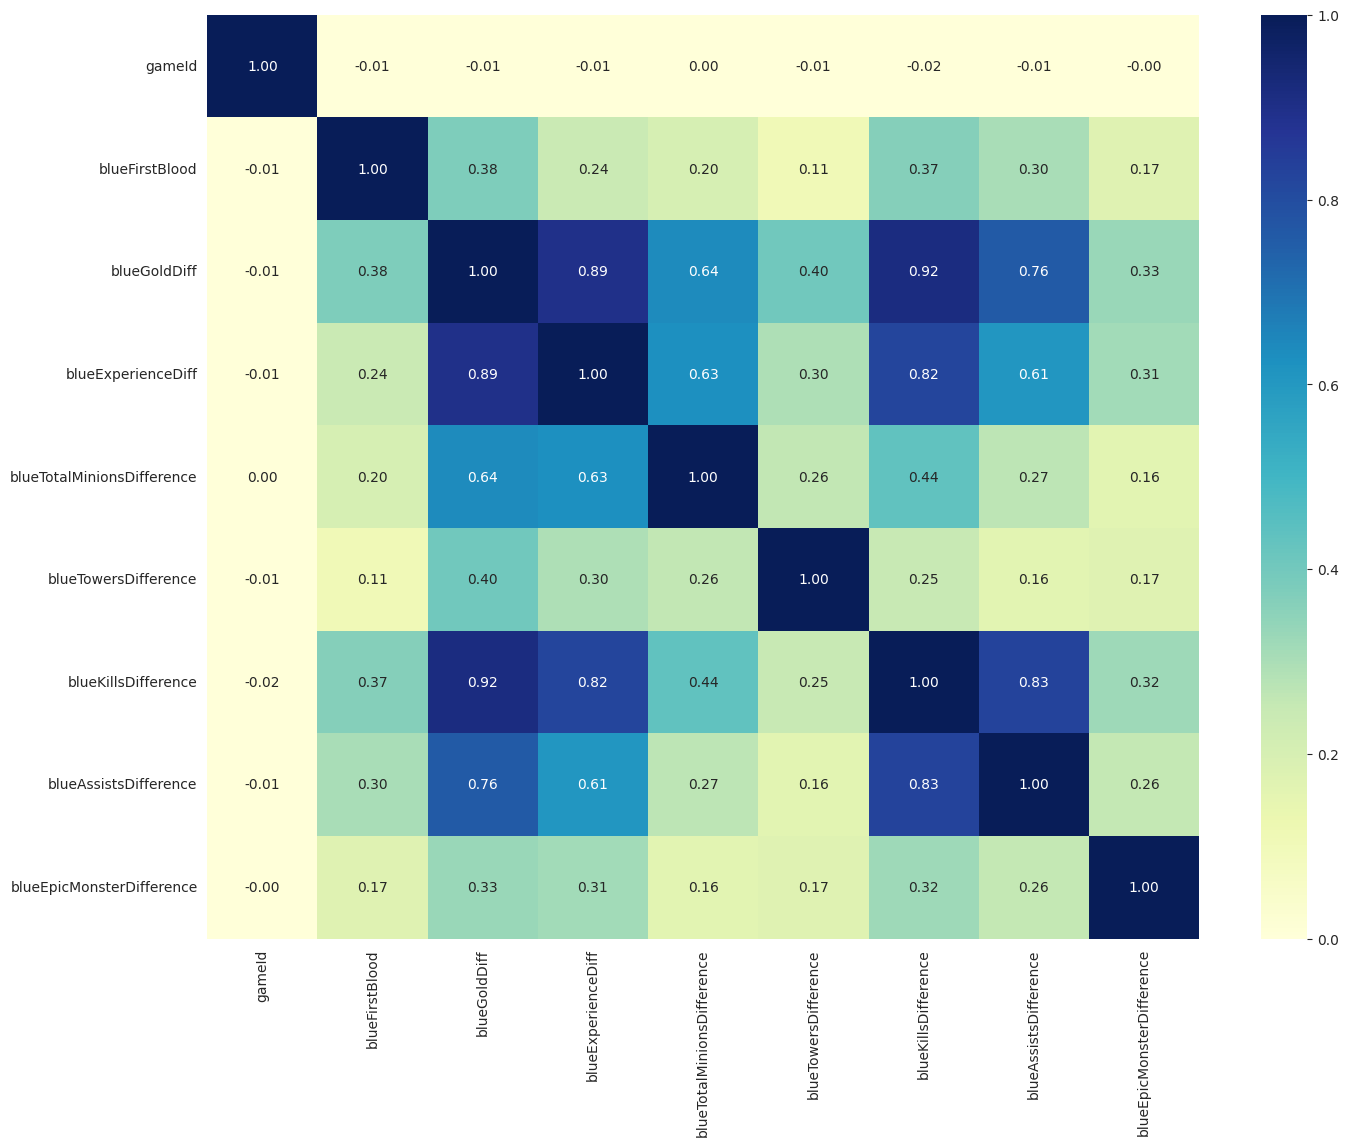

In [160]:
plt.figure(figsize=(16, 12))
sns.heatmap(df_clean.drop('blueWins', axis=1).corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0);

### Another Histogram!
More stuff! Most everything here are things that we already expected as before, just cleaned up and smushed together. In most statstical settings, .5 is the tradional confidence interval for determing if something is worth keeping in or not, even with us cleaning the data there are a number of criteria (like towers) that only *squek* by our rather generous confidence interval of .3

In [161]:
df_clean.head()

,gameId,blueWins,blueFirstBlood,blueGoldDiff,blueExperienceDiff,blueTotalMinionsDifference,blueTowersDifference,blueKillsDifference,blueAssistsDifference,blueEpicMonsterDifference
0,4519157822,0,1,643,-8,-2,0,3,3,0
1,4523371949,0,0,-2908,-1173,-66,-1,0,3,-2
2,4521474530,0,0,-1172,-1033,-17,0,-4,-10,1
3,4524384067,0,0,-1321,-7,-34,0,-1,-5,1
4,4436033771,0,0,-1004,230,-15,0,0,-1,-1


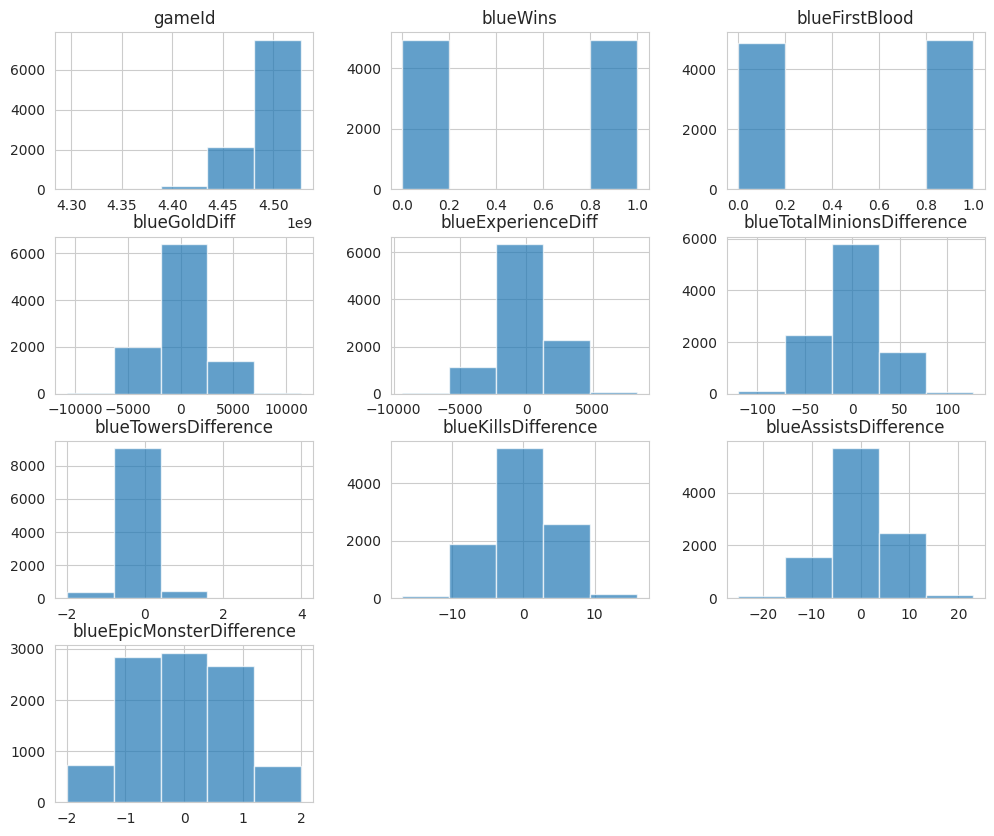

In [162]:
df_clean.hist(alpha = 0.7, figsize=(12,10), bins=5);
#A colection of histograms to see all our spreads! Note that Epics have the widest spread. 

## Graphs!

More data we've already scene, put into a different format. Do not the variance in epic monster kill and towers from the rest of the data pieces, implying them to be further removed from other data on this set. 

In [201]:
#And that's the data! Now, we build a predictive model that can pull everyting together for us. 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
X = df_clean
y = df['blueWins']

#Added this to deal with some data leakage
X_train_scaled = pd.DataFrame(X, columns=df_clean.columns)

X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y, test_size=0.2, random_state=33)
scaler = MinMaxScaler()
scaler.fit(X_train)
X = scaler.transform(X)

In [202]:
#Naive Bayes!
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# fit the model
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)

pred_nb = clf_nb.predict(X_test)

# get the accuracy score
acc_nb = accuracy_score(pred_nb, y_test)
print(acc_nb)

0.7110323886639676


## My Folly
So, your model should almost *never* assume a 1.0 accuracy. 1.0 accuracy usually implies a data leak of some variety; where your training data get's split up with your validation data. And I, after copoius testing and a variety of attempts, cannot figure out for the life of me why. 

In [203]:
# ...decision tree?
from sklearn import tree
from sklearn.model_selection import GridSearchCV

tree = tree.DecisionTreeClassifier()

# search the best params
grid = {'min_samples_split': [5, 10, 20, 50, 100]},

clf_tree = GridSearchCV(tree, grid, cv=5)
clf_tree.fit(X_train, y_train)

pred_tree = clf_tree.predict(X_test)

# get the accuracy score
acc_tree = accuracy_score(pred_tree, y_test)
print(acc_tree)

1.0


In [199]:
# Cmon, logistic regresion
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X_train, y_train)

# get accuracy score
pred_lm = lm.predict(X_test)
acc_lm = accuracy_score(pred_lm, y_test)
print(acc_lm)

0.49898785425101216


In [207]:
data_dict = {
    'Naive Bayes': [acc_nb], 
    'DT': [acc_tree],  
    'Logistic Regression': [acc_lm],
}
df_c = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Accuracy Score'])
print(df_c)

                     Accuracy Score
Naive Bayes                0.711032
DT                         1.000000
Logistic Regression        0.498988


# In Conclusion

Due to a few of my tests returing an accuracy of 1.0, I have decided to refrain from implimenting a model proper of this dataset, as I cannot guarantee that there was not a data leakage. Should anyone reading this happen too see what I cannot, please feel free to tell me why I am silly, and how I might fix that. Regardless, I leave this with a note of my observations.

## Summary

Gold and experiance are key. The team with the higher gold and or experiance (they are nearly 1:1 correlated) at the ten minute mark has a dramaticlly higher chance of winning the game. This is best predicted by in order,kills,CS,and *then* objectives. Losing an early tower, dragon, or herald is by my estamate about half as bad as signifigently being down in CS. Objectives are risky, diffucult things to take early, and a players time is better spent not dying and farming. Or, even better, killing your oponent so you can farm and they can't. This says nothing for the value of these things later on, as in my personal experiance this order seems to flip making objectives the most valuable, but broad advice is to focus first and formost on your economy.